<a href="https://colab.research.google.com/github/kalebmes/ML-and-DL-projects/blob/main/Chest%20X_ray%20classification/resnet_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia --unzip --force

100% 2.29G/2.29G [00:15<00:00, 173MB/s]
100% 2.29G/2.29G [00:15<00:00, 160MB/s]


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T

In [7]:
data_path = os.path.join('/content', 'chest_xray', 'chest_xray')
train_path = os.path.join(data_path, 'train')
validation_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

In [8]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
train_augs = T.Compose([T.RandomHorizontalFlip(p=0.5), 
                        T.RandomRotation(degrees=(-20, +20)), 
                        T.Resize((64, 64)),
                        T.ToTensor()])

valid_augs = T.Compose([T.Resize((64, 64)), T.ToTensor()])

In [9]:
trainset = ImageFolder(train_path, transform=train_augs)
validset = ImageFolder(validation_path, transform=valid_augs)
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 5216
Total no. of examples in validset : 16


In [10]:
print(trainset.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}


chosen index:  3337


Text(0.5, 1.0, '1')

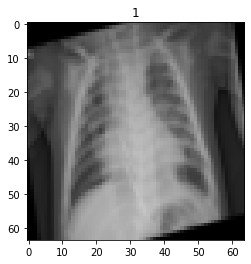

In [11]:
#we can view some images and their labels
import matplotlib.pyplot as plt
idx = np.random.randint(low=0, high=len(trainset)-1)
print('chosen index: ', idx)
image, label = trainset[idx] # the image has format of h, w, c -> so it have to be reshaped
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [12]:
lr = 1e-3
batch_size = 8
epochs = 30

#device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  print('GPU available')
else:
  print('training is done on CPU')

GPU available


In [13]:
#now let's read the dataset using pytorch's dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, )
validloader = DataLoader(validset, batch_size=batch_size)
print('total batches in trainloader: ', len(trainloader), 'and validloader: ', len(validloader))

total batches in trainloader:  652 and validloader:  2


In [16]:
from torchvision import models
model = models.resnet101(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.Linear(1024, 512),
    nn.Linear(512, 256),
    nn.Linear(256, 10),
    nn.Linear(10, 1))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from tqdm import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_model(model, dataloader, optimizer, current_epoch):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def eval_model(model, dataloader, current_epoch):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

In [ ]:
#now let's train the model
from torch import optim
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-2, nesterov=True)

In [ ]:
for images, labels in trainset:
  break
print('images batch shape: ', images.shape)
print('labels batch shape', labels)

images batch shape:  torch.Size([3, 64, 64])
labels batch shape 0


In [ ]:
best_valid_loss = np.Inf
for i in range(epochs):
  train_loss, train_acc = train_model(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_model(model, validloader, i)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVED BEST WEIGHTS')
    best_valid_loss = valid_loss
print()
print()
print('accuracy on the training set: ', float(train_acc))
print('accuracy on the validation set: ', float(valid_acc))

EPOCH[VALID]1/30: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s, loss=0.919, acc=0.562]


SAVED BEST WEIGHTS


EPOCH[VALID]3/30: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s, loss=0.711, acc=0.625]


SAVED BEST WEIGHTS


EPOCH[VALID]4/30: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s, loss=0.322, acc=0.812]


SAVED BEST WEIGHTS


EPOCH[VALID]5/30: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s, loss=0.274, acc=0.875]


SAVED BEST WEIGHTS


EPOCH[VALID]7/30: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s, loss=0.259, acc=0.875]


SAVED BEST WEIGHTS


EPOCH[VALID]9/30: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s, loss=0.201, acc=0.875]


SAVED BEST WEIGHTS


EPOCH[VALID]22/30: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s, loss=0.17, acc=0.875]


SAVED BEST WEIGHTS


EPOCH[VALID]30/30: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s, loss=0.203, acc=0.875]



accuracy on the training set:  0.9936733245849609
accuracy on the validation set:  0.875
